In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. Cargar los datos
datos = pd.read_csv('water_potability.csv').dropna()
print("Forma por defecto del dataset '.csv': \n", list(datos.keys()))

# 2. Preprocesar los datos si es necesario
X = datos.drop('Potability', axis=1)
y = datos['Potability']

# 3. Dividir los datos en conjuntos de entrenamiento y prueba
features = list(datos.keys())
features.remove('Potability')
X_train3, X_temp3, y_train3, y_temp3 = train_test_split(datos[features], datos['Potability'], test_size=0.2)
X_val3, X_test3, y_val3, y_test3 = train_test_split(X_temp3, y_temp3, test_size=0.5)

Forma por defecto del dataset '.csv': 
 ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


In [3]:
"""
Aquí secuestramos la función para normalizar que habíamos hecho en la tarea 1. Y luego la usamos para normalizar los datos de la tarea 3, en el punto 3.
Los datos de validación y test se normalizaron con la media y la desviación de los datos de entrenamiento
"""
parametros_train = dict(map(lambda x: (x, {'media': np.mean(X_train3[x]), 'desviacion': np.std(X_train3[x])}), X_train3.keys()))
def normalizar(dataSet, features, parametros = []):
    """
    Esta función resta la media y luego divide entre la desviación estandar de cada dato en cada columna. Si se le especifica la media y la desviación en los parámetros 
    Usa esa media y desviación dada, de lo contrario, calcula la media y la desviación de cada columna especificada en "features"
    @input: dataSet <pd.DataFrame>: Tabla de datos a la que se le va a dar normalización a la columans dadas
    @input: features <list>: lista de "features" o columnas que se van a normalizar
    @input: (opcional) parametros <dict>: En caso de que se quiera normalizar con una media y una desviación dada se especifican en un diccionario así: {'mileage':{'media': 2.9, 'desviacion': 7}}
    """
    if len(parametros) == 0:
        for feature in features:
            media = np.mean(dataSet[feature])
            desviacion = np.std(dataSet[feature])
            if desviacion != 0:
                dataSet[feature] = (dataSet[feature] - media)/desviacion
            #fin if 
        #fin for
    #fin if 
    else:
        for feature in features:
            media = parametros[feature]['media']
            desviacion = parametros[feature]['desviacion']
            if desviacion != 0:
                dataSet[feature] = (dataSet[feature] - media)/desviacion
            #fin if 
        #fin for
#fin función
normalizar(X_train3, features)
normalizar(X_val3, features, parametros_train)
normalizar(X_test3, features, parametros_train)
#X_train3['D'] = (1/len(X_train3.index))*np.ones(len(X_train3.index))

In [4]:
a = list(map(lambda x: x, X_train3.to_dict(orient = 'index')))
print(X_train3.to_dict(orient = 'index').values())

dict_values([{'ph': 0.12347732864838419, 'Hardness': -1.8303320550024442, 'Solids': 0.037327915456276506, 'Chloramines': 0.007267140006920013, 'Sulfate': 0.586761285409554, 'Conductivity': 0.656622133195024, 'Organic_carbon': -0.9287968656634845, 'Trihalomethanes': -0.6979592637564422, 'Turbidity': 0.31413845301293525}, {'ph': 0.40500633240632494, 'Hardness': 0.4054976126465421, 'Solids': -0.5297202675246134, 'Chloramines': 0.3426609604392503, 'Sulfate': -1.1286463245183749, 'Conductivity': -1.9326689044531542, 'Organic_carbon': -0.7955969927088763, 'Trihalomethanes': -0.5793709233782155, 'Turbidity': -0.9327559587824148}, {'ph': -0.18727955419445666, 'Hardness': 2.3352895117005037, 'Solids': -0.8628840167492344, 'Chloramines': 1.7620099212106715, 'Sulfate': 0.8490208899263404, 'Conductivity': 2.256907342683613, 'Organic_carbon': -1.5110365692771062, 'Trihalomethanes': 1.530037448060332, 'Turbidity': -0.6593944927626265}, {'ph': -0.623864905705789, 'Hardness': 1.6490801453510715, 'Soli

In [5]:
def AdaBoostear(datos, etiquetas, N_clasificadores):
    D = (1/len(datos.index))*np.ones(len(datos.index)) 
    lista_modelos = []
    for k in range(N_clasificadores):
        modelo = DecisionTreeClassifier(max_depth=1)
        modelo.fit(datos, etiquetas, sample_weight=D)
        estimaciones_modelo = modelo.predict(datos)
        aciertos = 0.5*((2*estimaciones_modelo - 1)*(2*etiquetas - 1) + 1)
        descaches = 1 - aciertos
        error_k = D.dot(descaches)
        alpha_k = 0.5*np.log((1-error_k)/error_k)
        vector_exponenciales = np.exp(-alpha_k*(2*aciertos - 1))
        z_k = D.dot(vector_exponenciales)
        D_nuevo = (1/z_k)*(D*vector_exponenciales)
        lista_modelos.append({'alpha': alpha_k, 'arbol': modelo, 'D': D, 'Error': error_k})
        D = D_nuevo[:]
    #fin for
    return lista_modelos
#fin función

In [6]:
modelo_adaboost_train = AdaBoostear(X_train3, y_train3, 600)
modelo_adaboost_validate = AdaBoostear(X_val3, y_val3, 600)

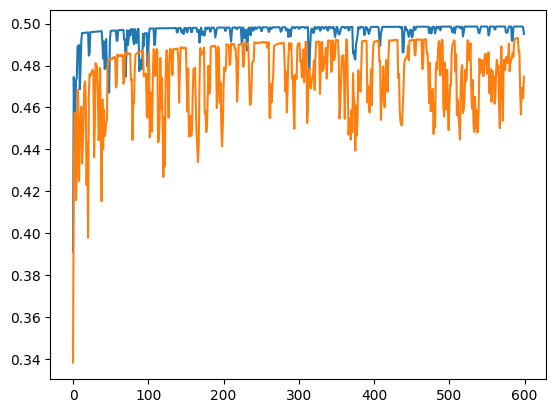

In [7]:
N_puntos = 600
iteracion = np.linspace(0,N_puntos - 1, N_puntos)
errores_train = list(map(lambda x: x['Error'], modelo_adaboost_train))[:N_puntos]
errores_val = list(map(lambda x: x['Error'], modelo_adaboost_validate))[:N_puntos]
fig1 = plt.figure()
plt.plot(iteracion, errores_train, iteracion, errores_val)

In [21]:
def Evaluar_Adaboost(datos, lista_dic_adaboost):
    suma = 0
    for i in range(len(lista_dic_adaboost)):
        termino = lista_dic_adaboost[i]['alpha']*(2*lista_dic_adaboost[i]['arbol'].predict(datos) - 1)
        suma += termino
    #fin for
    return 0.5*(np.sign(suma) + 1)
#fin funcion

In [22]:
evaluacion_train = Evaluar_Adaboost(X_train3, modelo_adaboost_train)
evaluacion_test = Evaluar_Adaboost(X_test3, modelo_adaboost_train)

In [23]:
print(evaluacion_train)

[0. 0. 1. ... 0. 0. 0.]
